# Import supporting package

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=4, processes=True, memory_limit='10GB')
client

<Client: 'tcp://127.0.0.1:59304' processes=6 threads=24, memory=55.88 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + "2023/05/09" # get_date()

## Check the stability of our BEC

The detected scaning axes and values are: 

{'runs': array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.

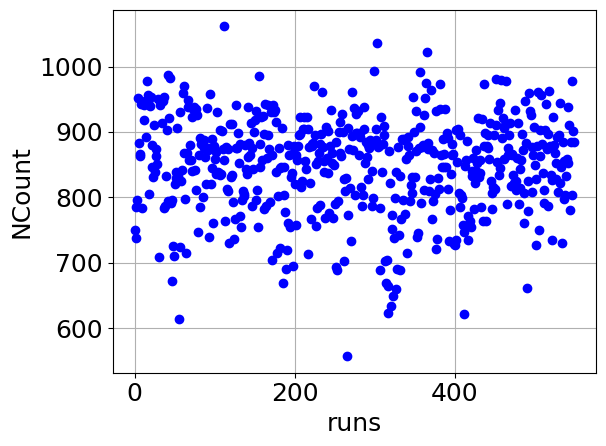

In [5]:
shotNum = "0007"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetOfGlobalDict = {
    dskey[groupList[i]]: read_hdf5_global(filePath, groupList[i])
    for i in [0]
}

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i], datesetOfGlobal=dataSetOfGlobalDict[dskey[groupList[i]]])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)
dataSet = swap_xy(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (959, 876)
imageAnalyser.span = (100, 100)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD).load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [6]:
dataSet_cropOD = auto_rechunk(dataSet_cropOD)

fitAnalyser = FitAnalyser("Two Gaussian-2D", fitDim=2)
params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params, dask="parallelized").load()

fitValue = fitAnalyser.get_fit_value(fitResult)
fitStd = fitAnalyser.get_fit_std(fitResult)

In [7]:
BEC_Ncount_val = fitValue['A_amplitude']
BEC_Ncount_std = fitStd['A_amplitude']

thermal_Ncount_val = fitValue['B_amplitude']
thermal_Ncount_std = fitStd['B_amplitude']

BEC_width_x_val = fitValue['A_sigmax']
BEC_width_x_std = fitStd['A_sigmax']
BEC_width_y_val = fitValue['A_sigmay']
BEC_width_y_std = fitStd['A_sigmay']

thermal_width_x_val = fitValue['B_sigmax']
thermal_width_x_std = fitStd['B_sigmax']
thermal_width_y_val = fitValue['B_sigmay']
thermal_width_y_std = fitStd['B_sigmay']

BEC_center_x_val = fitValue['A_centerx']
BEC_center_x_std = fitStd['A_centerx']
BEC_center_y_val = fitValue['A_centery']
BEC_center_y_std = fitStd['A_centery']

thermal_center_x_val = fitValue['B_centerx']
thermal_center_x_std = fitStd['B_centerx']
thermal_center_y_val = fitValue['B_centery']
thermal_center_y_std = fitStd['B_centery']

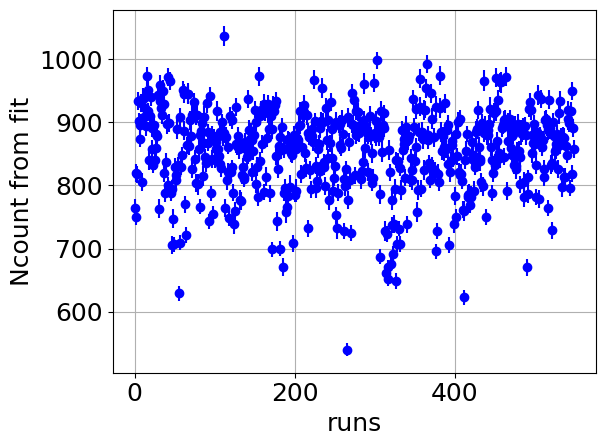

<xarray.DataArray ()>
array(853.42940839)


In [8]:
total_Ncount_val = BEC_Ncount_val + thermal_Ncount_val
total_Ncount_std = BEC_Ncount_std + thermal_Ncount_std

fig = plt.figure()
ax = fig.gca()

total_Ncount_val.plot.errorbar(ax=ax, yerr=total_Ncount_std, fmt='ob')
# plt.ylim([0, 1100])
plt.ylabel('Ncount from fit')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

print(total_Ncount_val.mean())

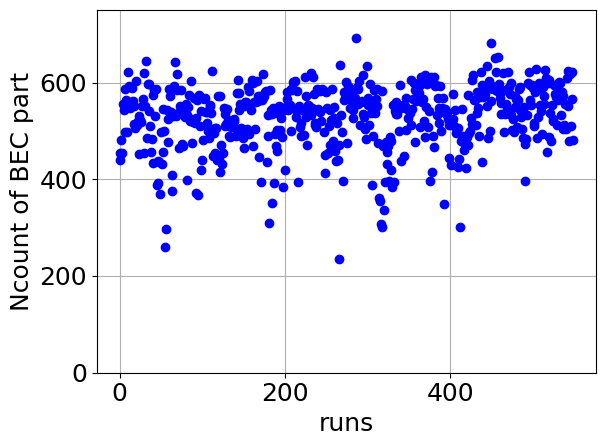

In [9]:
fig = plt.figure()
ax = fig.gca()

BEC_Ncount_val.plot.errorbar(ax=ax, yerr=BEC_Ncount_std, fmt='ob')
plt.ylim([0, 750])
plt.ylabel('Ncount of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

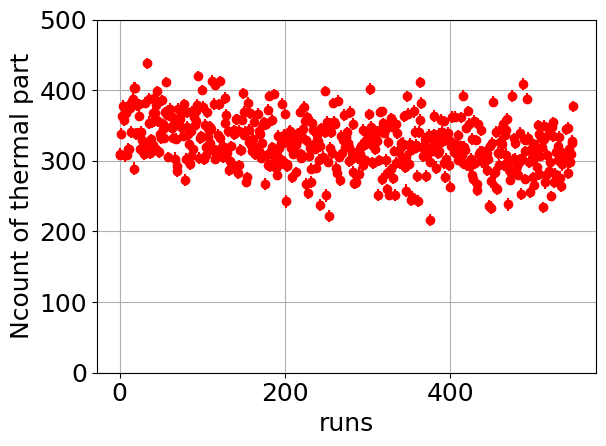

In [10]:
fig = plt.figure()
ax = fig.gca()

thermal_Ncount_val.plot.errorbar(ax=ax, yerr=thermal_Ncount_std, fmt='or')
plt.ylim([0, 500])
plt.ylabel('Ncount of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

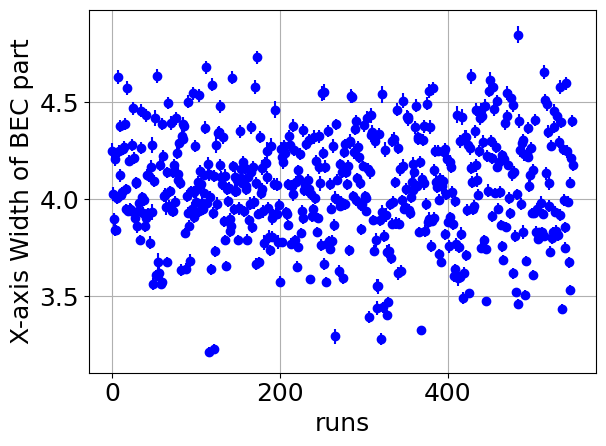

In [11]:
fig = plt.figure()
ax = fig.gca()

BEC_width_x_val.plot.errorbar(ax=ax, yerr=BEC_width_x_std, fmt='ob')

plt.ylabel('X-axis Width of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

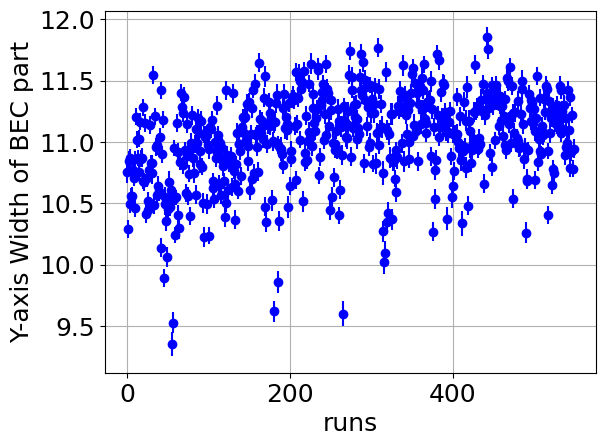

In [12]:
fig = plt.figure()
ax = fig.gca()

BEC_width_y_val.plot.errorbar(ax=ax, yerr=BEC_width_y_std, fmt='ob')

plt.ylabel('Y-axis Width of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

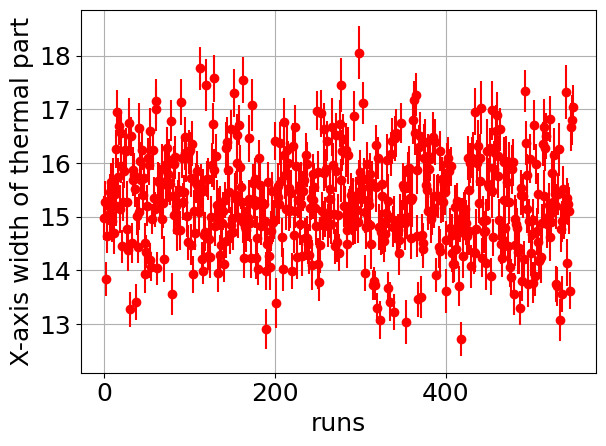

In [13]:
fig = plt.figure()
ax = fig.gca()

thermal_width_x_val.plot.errorbar(ax=ax, yerr=thermal_width_x_std, fmt='or')

plt.ylabel('X-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

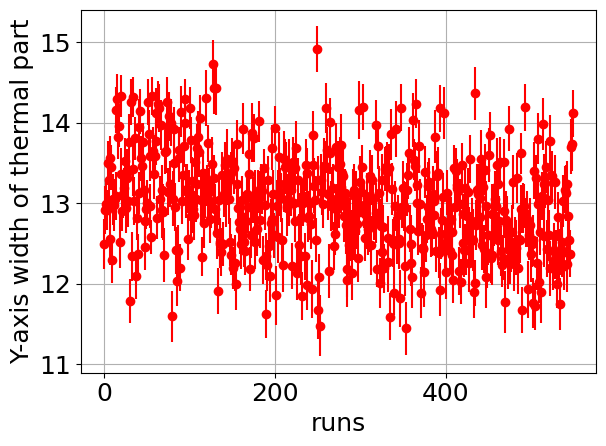

In [14]:
fig = plt.figure()
ax = fig.gca()

thermal_width_y_val.plot.errorbar(ax=ax, yerr=thermal_width_y_std, fmt='or')

plt.ylabel('Y-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

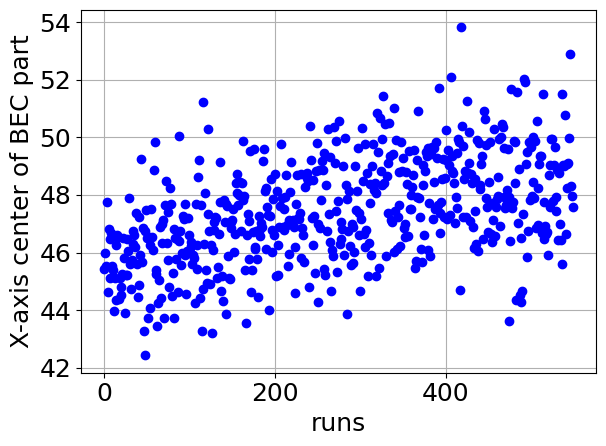

In [15]:
fig = plt.figure()
ax = fig.gca()

BEC_center_x_val.plot.errorbar(ax=ax, yerr=BEC_center_x_std, fmt='ob')

plt.ylabel('X-axis center of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

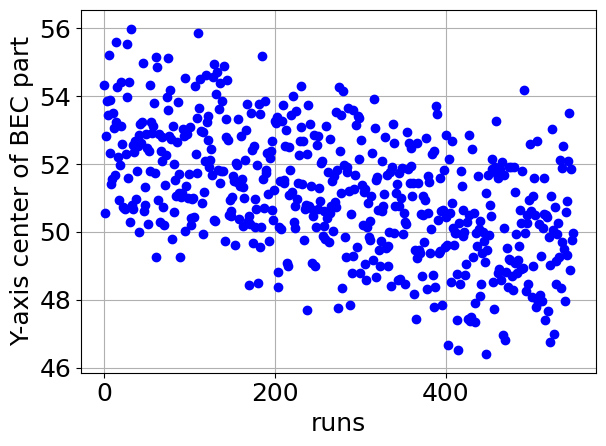

In [16]:
fig = plt.figure()
ax = fig.gca()

BEC_center_y_val.plot.errorbar(ax=ax, yerr=BEC_center_y_std, fmt='ob')

plt.ylabel('Y-axis center of BEC part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

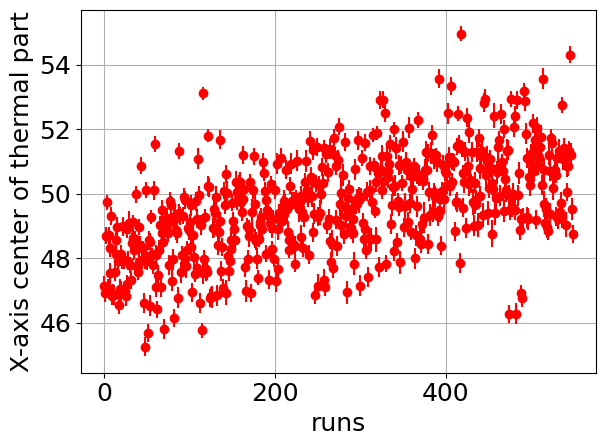

In [17]:
fig = plt.figure()
ax = fig.gca()

thermal_center_x_val.plot.errorbar(ax=ax, yerr=thermal_center_x_std, fmt='or')

plt.ylabel('X-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

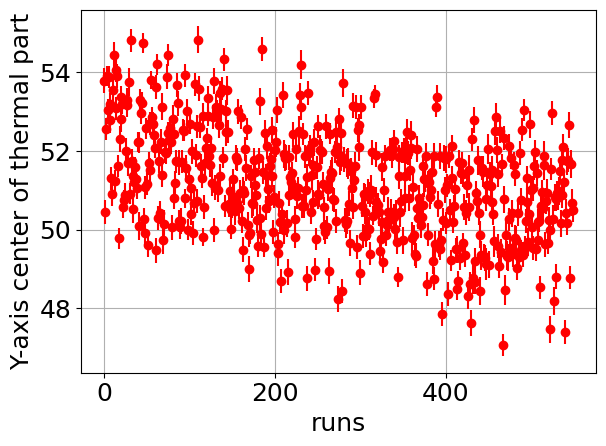

In [18]:
fig = plt.figure()
ax = fig.gca()

thermal_center_y_val.plot.errorbar(ax=ax, yerr=thermal_center_y_std, fmt='or')

plt.ylabel('Y-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

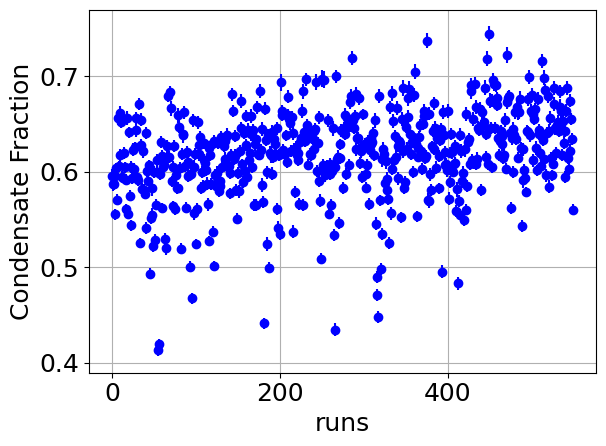

In [19]:
fitFullResult = fitAnalyser.get_fit_full_result(fitResult)
condensateFraction = fitFullResult['A_amplitude'] / (fitFullResult['A_amplitude'] + fitFullResult['B_amplitude'])
condensateFraction_value, condensateFraction_std = seperate_uncertainty(condensateFraction)

fig = plt.figure()
ax = fig.gca()

condensateFraction_value.plot.errorbar(ax=ax, yerr=condensateFraction_std, fmt='ob')

plt.ylabel('Condensate Fraction')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [20]:
val = Ncount.mean().item()
std = Ncount.std().item()
print(f'The total Ncount is: {val: .2f} \u00B1 {std: .2f}')

val = total_Ncount_val.mean().item()
std = total_Ncount_val.std().item()
print(f'The total Ncount from fit is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_Ncount_val.mean().item()
std = BEC_Ncount_val.std().item()
print(f'The Ncount of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_Ncount_val.mean().item()
std = thermal_Ncount_val.std().item()
print(f'The Ncount of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_width_x_val.mean().item()
std = BEC_width_x_val.std().item()
print(f'The x-axis width of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_width_y_val.mean().item()
std = BEC_width_y_val.std().item()
print(f'The y-axis width of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_x_val.mean().item()
std = thermal_width_x_val.std().item()
print(f'The x-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_y_val.mean().item()
std = thermal_width_y_val.std().item()
print(f'The y-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_center_x_val.mean().item()
std = BEC_center_x_val.std().item()
print(f'The x-axis center of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = BEC_center_y_val.mean().item()
std = BEC_center_y_val.std().item()
print(f'The y-axis center of the BEC part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_x_val.mean().item()
std = thermal_center_x_val.std().item()
print(f'The x-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_y_val.mean().item()
std = thermal_center_y_val.std().item()
print(f'The y-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = condensateFraction_value.mean().item()
std = condensateFraction_value.std().item()
print(f'The condensate fraction is: {val: .4f} \u00B1 {std: .4f}')

The total Ncount is:  849.84 ±  73.69
The total Ncount from fit is:  853.43 ±  66.18
The Ncount of the BEC part is:  528.79 ±  65.37
The Ncount of the thermal part is:  324.64 ±  35.62
The x-axis width of the BEC part is:  4.06 ±  0.28
The y-axis width of the BEC part is:  11.03 ±  0.36
The x-axis width of the thermal part is:  15.30 ±  0.91
The y-axis width of the thermal part is:  12.99 ±  0.61
The x-axis center of the BEC part is:  47.44 ±  1.82
The y-axis center of the BEC part is:  51.13 ±  1.83
The x-axis center of the thermal part is:  49.62 ±  1.54
The y-axis center of the thermal part is:  51.17 ±  1.37
The condensate fraction is:  0.6180 ±  0.0464


In [21]:
i=0
runTime = read_hdf5_run_time(filePath, datesetOfGlobal=dataSetOfGlobalDict[dskey[groupList[i]]])
runTime

<xarray.Dataset>
Dimensions:  (runs: 550)
Coordinates:
  * runs     (runs) float64 0.0 1.0 2.0 3.0 4.0 ... 546.0 547.0 548.0 549.0
Data variables:
    runTime  (runs) datetime64[ns] 2023-05-09T14:30:03 ... 2023-05-09T15:56:53
Attributes: (12/101)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    y_offset_img:                      0
    z_offset:                          0.189
    z_offset_img:                      0.189
    runs:                              [  0.   1.   2.   3.   4.   5.   6.   ...
    scanAxis:                          ['runs']
    scanAxisLength:                    [550.]

In [23]:
time = runTime.runTime.to_numpy()
time0 = int(time[0])
time = np.array(
    [
        float(value) - time0
        for value in time
    ]
)
time = time / time.max() * 2 * np.pi

In [24]:
Ncount_time = xr.DataArray(
    data=Ncount,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)
Ncount_time

<xarray.DataArray 'OD' (time: 550)>
array([ 750.47641876,  738.34281204,  784.41476569,  796.02169322,
        952.51855344,  882.92079597,  863.59651678,  866.57709198,
        941.99125428,  783.16551019,  946.27689189,  918.33176133,
        941.81141492,  947.74774665,  892.61913887,  977.17520626,
        945.34126351,  956.52682689,  804.78165476,  939.49484698,
        953.56682753,  879.61475127,  846.05592616,  830.90774024,
        910.80224254,  839.43361196,  863.23083974,  873.50170576,
        850.29285459,  949.59349556,  707.93266373,  946.74069024,
        941.71185143,  946.57095286,  914.32343568,  947.09283187,
        954.03294364,  784.23261906,  786.97273688,  832.62952621,
        903.46885276,  794.84132388,  987.33131008,  920.97693631,
        982.49210229,  790.82171889,  796.04783468,  672.41580595,
        726.07270248,  709.64654892,  820.34697312,  839.24755133,
        830.20821813,  905.60581009,  832.01909227,  614.3819873 ,
        723.89815083,  930.88065587,  825.30243762,  842.16853182,
        960.03822443,  970.87588969,  867.93951095,  796.77918204,
        715.07236109,  867.86554561,  949.15778283,  938.56330193,
        857.52360377,  880.71776388,  856.94886599,  923.54732893,
        840.56332593,  934.82056594,  938.21743126,  841.27262899,
        935.776538  ,  810.94173848,  926.17365109,  746.68729357,
...
        865.51482127,  833.61692314,  821.20906768,  933.87516973,
        810.80092789,  824.63722508,  859.85285532,  913.23783203,
        789.32182143,  814.52479359,  843.87902457,  857.31154799,
        896.47897516,  872.95758519,  761.01860691,  806.85333498,
        947.18607913,  882.95786654,  660.90304299,  779.06534297,
        824.68260644,  960.00725562,  931.83023265,  925.32091745,
        876.67147414,  808.28701944,  865.12927984,  907.22865863,
        849.53390823,  827.70871779,  726.90703872,  878.79705242,
        960.28888691,  750.46295033,  903.46216093,  862.60511899,
        956.07697944,  881.35524969,  837.32695128,  791.87607618,
        811.78036383,  902.4373154 ,  942.28581666,  874.3906838 ,
        896.64409276,  787.28302139,  963.13514734,  877.87315412,
        833.86614596,  826.5946265 ,  735.16788438,  922.53477054,
        880.6268579 ,  867.12639832,  852.01398293,  828.11720597,
        891.6310036 ,  807.47838578,  895.25022758,  822.18630467,
        943.8055441 ,  845.66585589,  729.57792525,  884.88667118,
        796.64506694,  855.18595889,  803.11938466,  832.46778894,
        858.2150589 ,  937.40605043,  853.13728532,  910.90015676,
        780.99561864,  883.83375992,  804.26394636,  978.32360651,
        901.75651529,  884.02352999])
Coordinates:
  * time     (time) datetime64[ns] 2023-05-09T14:30:03 ... 2023-05-09T15:56:53

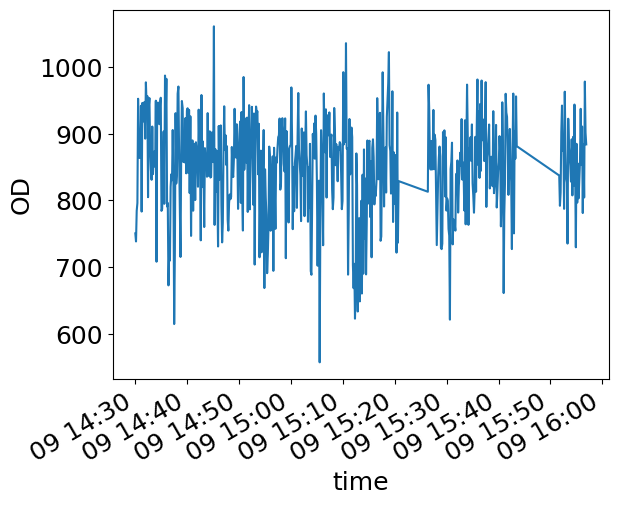

In [25]:
Ncount_time.plot()

(0.0, 70000.0)

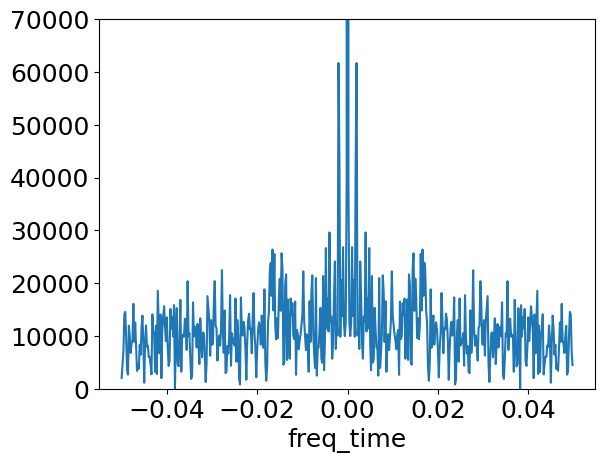

In [26]:
Ncount_time_interp = Ncount_time.interp(time=pd.date_range("2023-05-09T14:30:03.000000000", "2023-05-09T15:56:53.000000000", periods=500))
da_fft = xrft.fft(Ncount_time_interp)
da_fft_amp = np.abs(da_fft)
# da_fft_amp.isel(freq_time=range(251,370)).plot()
da_fft_amp.plot()
# plt.xlim([-0.05, 0.05])
plt.ylim([0, 7e4])

(0.0, 70000.0)

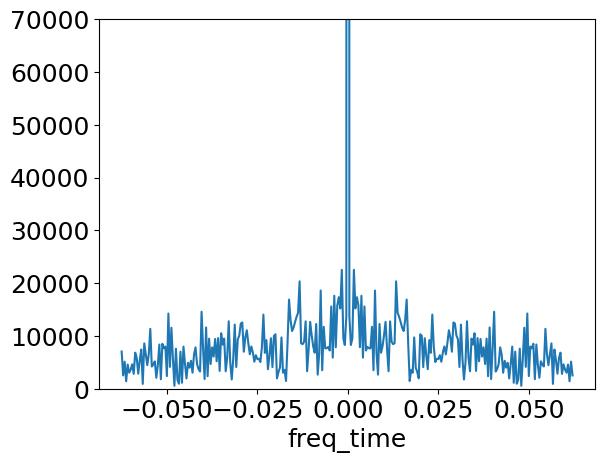

In [27]:
# da_test2.isel(time=range(300)).plot()
da_fft = xrft.fft(
    Ncount_time.isel(time=range(300)).interp(
        time=pd.date_range(
            Ncount_time.time[0].item(), Ncount_time.time[299].item(), periods=300
            # "2023-05-09T14:30:03.000000000", "2023-05-09T15:10:06.000000000", periods=300
        )
    )
)
# np.abs(da_fft).isel(freq_time=range(151,300)).plot()
np.abs(da_fft).plot()
# plt.xlim([0, 0.003])
plt.ylim([0, 7e4])
# plt.yscale("log")

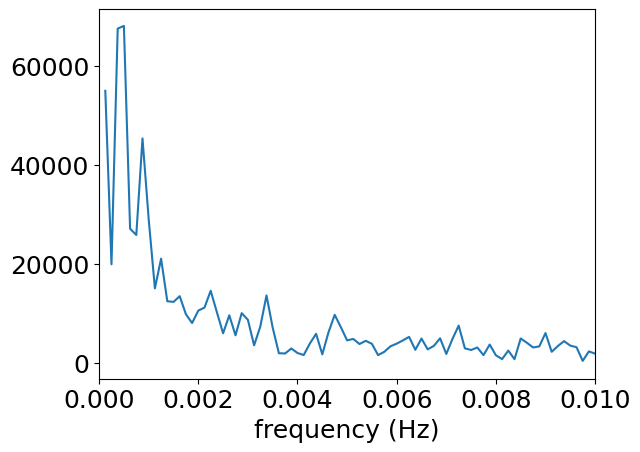

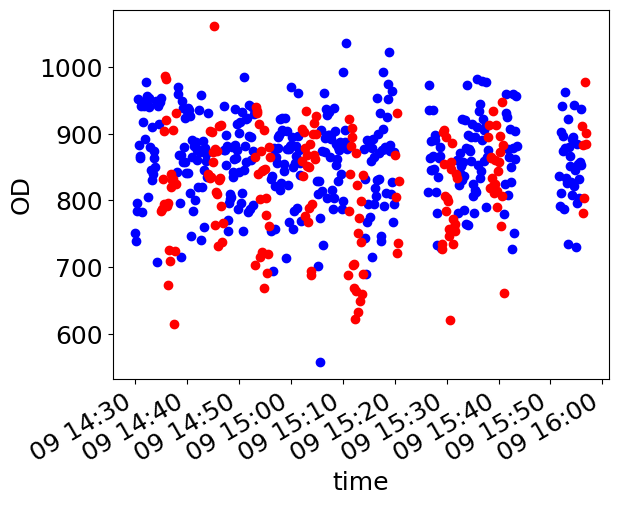

In [28]:
analyserDataArray = Ncount

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

value = np.abs(f)
value[int((N-1)/2)] = np.nan
value.where(value.time_freq>0).plot()
plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.xlabel('frequency (Hz)')
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
analyserDataArray = BEC_Ncount_val

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

value = np.abs(f)
value[int((N-1)/2)] = np.nan
value.where(value.time_freq>0).plot()
plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
analyserDataArray = BEC_width_x_val

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

value = np.abs(f)
value[int((N-1)/2)] = np.nan
value.where(value.time_freq>0).plot()
plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
analyserDataArray = thermal_width_y_val

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

np.abs(f).plot()
# plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
analyserDataArray = BEC_center_y_val

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

np.abs(f).plot()
# plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
analyserDataArray = thermal_center_y_val

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

np.abs(f).plot()
# plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
analyserDataArray = condensateFraction_value

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 1001

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

np.abs(f).plot()
# plt.xlim([0, 0.01])
# plt.ylim([0, 2000])
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

## Close to the BEC transition point, in evaporative cooling 2 with truncation value = 0.77

In [ ]:
shotNum = "0015"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (879, 956)
imageAnalyser.span = (200, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD).load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')
plt.ylim([0, 3000])
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet_cropOD = auto_rechunk(dataSet_cropOD)

fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)
params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params, dask="parallelized").load()

fitValue = fitAnalyser.get_fit_value(fitResult)
fitStd = fitAnalyser.get_fit_std(fitResult)

In [ ]:
thermal_Ncount_val = fitValue['amplitude']
thermal_Ncount_std = fitStd['amplitude']

thermal_width_x_val = fitValue['sigmax']
thermal_width_x_std = fitStd['sigmax']
thermal_width_y_val = fitValue['sigmay']
thermal_width_y_std = fitStd['sigmay']

thermal_center_x_val = fitValue['centerx']
thermal_center_x_std = fitStd['centerx']
thermal_center_y_val = fitValue['centery']
thermal_center_y_std = fitStd['centery']

In [ ]:
total_Ncount_val = thermal_Ncount_val
total_Ncount_std = thermal_Ncount_std

fig = plt.figure()
ax = fig.gca()

total_Ncount_val.plot.errorbar(ax=ax, yerr=total_Ncount_std, fmt='ob')
plt.ylim([0, 3000])
plt.ylabel('Ncount from fit')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_x_val.plot.errorbar(ax=ax, yerr=thermal_width_x_std, fmt='or')

plt.ylabel('X-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_y_val.plot.errorbar(ax=ax, yerr=thermal_width_y_std, fmt='or')

plt.ylabel('Y-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_x_val.plot.errorbar(ax=ax, yerr=thermal_center_x_std, fmt='or')

plt.ylabel('X-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_y_val.plot.errorbar(ax=ax, yerr=thermal_center_y_std, fmt='or')

plt.ylabel('Y-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
val = Ncount.mean().item()
std = Ncount.std().item()
print(f'The total Ncount is: {val: .2f} \u00B1 {std: .2f}')

val = total_Ncount_val.mean().item()
std = total_Ncount_val.std().item()
print(f'The total Ncount from fit is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_x_val.mean().item()
std = thermal_width_x_val.std().item()
print(f'The x-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_y_val.mean().item()
std = thermal_width_y_val.std().item()
print(f'The y-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_x_val.mean().item()
std = thermal_center_x_val.std().item()
print(f'The x-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_y_val.mean().item()
std = thermal_center_y_val.std().item()
print(f'The y-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

In [ ]:
i=0
runTime = read_hdf5_run_time(filePath, datesetOfGlobal=dataSetOfGlobalDict[dskey[groupList[i]]])

In [ ]:
time = runTime.runTime.to_numpy()
time0 = int(time[0])
time = np.array(
    [
        float(value) - time0
        for value in time
    ]
)
time = time / time.max() * 2 * np.pi

In [ ]:
analyserDataArray = Ncount

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 701

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

value = np.abs(f)
value[int((N-1)/2)] = np.nan
value.where(value.time_freq>0).plot()
# plt.xlim([0, 0.02])
# plt.ylim([0, 2000])
plt.xlabel('frequency (Hz)')
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

## At the end of ODT loading

In [ ]:
shotNum = "0020"
filePath = folderPath + "/" + shotNum + "/*.h5"

dataSetDict = {
    dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
    for i in [0]
}

dataSet = dataSetDict["camera_0"]

print_scanAxis(dataSet)

scanAxis = get_scanAxis(dataSet)

dataSet = auto_rechunk(dataSet)

dataSet = imageAnalyser.get_absorption_images(dataSet)

imageAnalyser.center = (550, 800)
imageAnalyser.span = (900, 1600)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()

Ncount = imageAnalyser.get_Ncount(dataSet_cropOD).load()

fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')

plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet

In [ ]:
fig = plt.figure()
ax = fig.gca()

Ncount.plot.errorbar(ax=ax, fmt='ob')
plt.ylim([0, 150000])
plt.ylabel('NCount')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
dataSet_cropOD = dataSet_cropOD.chunk((1, 900, 1600))
dataSet_cropOD

In [ ]:
# dataSet_cropOD = auto_rechunk(dataSet_cropOD)

fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)
params = fitAnalyser.guess(dataSet_cropOD, dask="parallelized")
fitResult = fitAnalyser.fit(dataSet_cropOD, params, dask="parallelized").load()

fitValue = fitAnalyser.get_fit_value(fitResult)
fitStd = fitAnalyser.get_fit_std(fitResult)

In [ ]:
thermal_Ncount_val = fitValue['amplitude']
thermal_Ncount_std = fitStd['amplitude']

thermal_width_x_val = fitValue['sigmax']
thermal_width_x_std = fitStd['sigmax']
thermal_width_y_val = fitValue['sigmay']
thermal_width_y_std = fitStd['sigmay']

thermal_center_x_val = fitValue['centerx']
thermal_center_x_std = fitStd['centerx']
thermal_center_y_val = fitValue['centery']
thermal_center_y_std = fitStd['centery']

In [ ]:
total_Ncount_val = thermal_Ncount_val
total_Ncount_std = thermal_Ncount_std

fig = plt.figure()
ax = fig.gca()

total_Ncount_val.plot.errorbar(ax=ax, yerr=total_Ncount_std, fmt='ob')
plt.ylim([0, 160000])
plt.ylabel('Ncount from fit')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_x_val.plot.errorbar(ax=ax, yerr=thermal_width_x_std, fmt='or')

plt.ylabel('Y-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_width_y_val.plot.errorbar(ax=ax, yerr=thermal_width_y_std, fmt='or')

plt.ylabel('X-axis width of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_x_val.plot.errorbar(ax=ax, yerr=thermal_center_x_std, fmt='or')

plt.ylabel('Y-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.gca()

thermal_center_y_val.plot.errorbar(ax=ax, yerr=thermal_center_y_std, fmt='or')

plt.ylabel('X-axis center of thermal part')
plt.tight_layout()
plt.grid(visible=1)
plt.show()

In [ ]:
val = Ncount.mean().item()
std = Ncount.std().item()
print(f'The total Ncount is: {val: .2f} \u00B1 {std: .2f}')

val = total_Ncount_val.mean().item()
std = total_Ncount_val.std().item()
print(f'The total Ncount from fit is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_x_val.mean().item()
std = thermal_width_x_val.std().item()
print(f'The y-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_width_y_val.mean().item()
std = thermal_width_y_val.std().item()
print(f'The x-axis width of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_x_val.mean().item()
std = thermal_center_x_val.std().item()
print(f'The y-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

val = thermal_center_y_val.mean().item()
std = thermal_center_y_val.std().item()
print(f'The x-axis center of the thermal part is: {val: .2f} \u00B1 {std: .2f}')

In [ ]:
i=0
runTime = read_hdf5_run_time(filePath, datesetOfGlobal=dataSetOfGlobalDict[dskey[groupList[i]]])

In [ ]:
time = runTime.runTime.to_numpy()
time0 = int(time[0])
time = np.array(
    [
        float(value) - time0
        for value in time
    ]
)
time = time / time.max() * 2 * np.pi

In [ ]:
analyserDataArray = Ncount

analyserDataArray_time = xr.DataArray(
    data=analyserDataArray,
    dims=["time"],
    coords={
        "time": runTime.runTime.to_numpy(),
    }
)

# desired number of Fourier modes (uniform outputs)
N = 701

# calculate the transform
analyserDataArray_time_array = analyserDataArray_time.to_numpy()
analyserDataArray_time_array = np.array(analyserDataArray_time_array, dtype=complex)
f = xr.DataArray(
    data=finufft.nufft1d1(time, analyserDataArray_time_array, N),
    dims=['time_freq'],
    coords={
        "time_freq":np.linspace(-0.125/2,0.125/2,N)
    }
)

value = np.abs(f)
value[int((N-1)/2)] = np.nan
value.where(value.time_freq>0).plot()
# plt.xlim([0, 0.02])
# plt.ylim([0, 2000])
plt.xlabel('frequency (Hz)')
plt.show()

mask = xr.DataArray(
    data = np.full(runTime.runTime.shape,fill_value=False, dtype=bool),
    dims = ["time"],
    coords = {
        "time":runTime.runTime.to_numpy()
    }
)

for i in range(len(mask)):
    if (int(mask.time[i]) - 1683642540000000000) % 5.4e11 > 3.6e11:
        mask[i] = True

fig = plt.figure()
ax = fig.gca()

xr.where(mask, np.nan, analyserDataArray_time).plot.errorbar(fmt='ob')
analyserDataArray_time.where(mask).plot.errorbar(fmt='or')

plt.show()

In [ ]:
l = list(np.arange(0.001, 0.025, 0.0005))
# l = np.logspace(np.log10(100e-3), np.log10(20), num=20)

l = [round(item, 7) for item in l]
#random.shuffle(l)

print(l)
print(len(l))
np.mean(l)

## ODT 1 Calibration

In [ ]:
v_high = 2.7
"""High Power"""
P_arm1_high = 5.776 * v_high - 0.683

v_mid = 0.2076
"""Intermediate Power"""
P_arm1_mid = 5.815 * v_mid - 0.03651

v_low = 0.0587
"""Low Power"""
P_arm1_low = 5271 * v_low - 27.5

print(round(P_arm1_high, 3))
print(round(P_arm1_mid, 3))
print(round(P_arm1_low, 3))

## ODT 2 Power Calibration

In [ ]:
v = 0.7607
P_arm2 = 2.302 * v - 0.06452
print(round(P_arm2, 3))